<a href="https://colab.research.google.com/github/salexey1990/gb/blob/master/ml-algorithms/hw07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Реализуем алгоритм kNN с помощью Python.

In [0]:
import numpy as np
from sklearn import model_selection
from sklearn import datasets
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from itertools import combinations
from sklearn.metrics import r2_score

In [0]:
# сгенерируем данные
regression_data, regression_labels = datasets.make_regression(n_features = 2, n_informative = 2, random_state=5, n_samples=100)

In [0]:
# Разобьем выборку на обучающую и тестовую

X_train, X_test, y_train, y_test = model_selection.train_test_split(regression_data, 
                                                                                     regression_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

Используем евклидову метрику. Реализуем функцию для ее подсчета.

In [0]:
def e_metrics(x1, x2):
    
    distance = 0
    for i in range(len(x1)):
        distance += np.square(x1[i] - x2[i])
    
    return np.sqrt(distance)

In [0]:
# Реализуем функцию расчёта весов по дистанции между объектами

def calc_weight(distance):
  a = 1e-5
  weight = 1 / (distance + a)
  return weight

In [0]:
# Реализуем функцию предсказания значения, с учётом весов

def calc_prediction(weights):
  weighted_sum = 0
  weight_product = 1
  combination_sum = 0

  for value, weight in weights.items():
    weighted_sum += value/weight
    weight_product *= weight

  for x in list(combinations(weights.values(), len(weights.values())-1)):
    combination_sum += np.prod(x)

  prediction = (weight_product/combination_sum) * weighted_sum

  return prediction

Реализуем алгоритм поиска k ближайших соседей.

In [0]:
def knn(x_train, y_train, x_test, k):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
        

        # Сортируем список и среди первых k элементов подсчитаем веса этих элементов, основанные на дистанции до них
        weights = {}
        for d in sorted(test_distances)[0:k]:
            weights[d[1]] = calc_weight(d[0])
            
        answers.append(calc_prediction(weights))
        
    return answers

Напишем функцию для вычисления точности

In [0]:
# Введем функцию подсчета точности как среднюю квадратичную ошибку
def mse_metric(actual, predicted):
    return np.average((actual - predicted) ** 2, axis=0)

Проверим работу алгоритма при различных k

In [9]:
k = 3

y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {mse_metric(y_test, y_pred):.3f}')


Точность алгоритма при k = 3: 296.436


# 2

In [0]:
from sklearn.datasets import make_blobs
import random

X, y = make_blobs(n_samples=100, random_state=1)

Изобразим точки на графике.

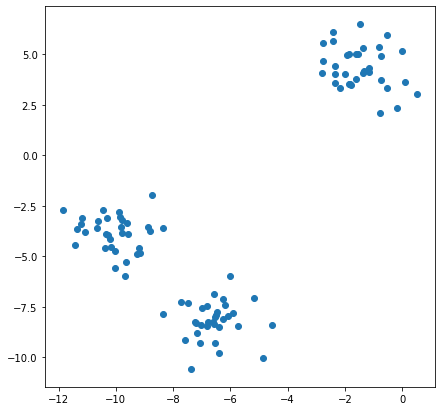

In [11]:
plt.figure(figsize=(7,7))
plt.scatter(X[:, 0], X[:, 1])

В качестве метрики расстояния будем использовать евклидово расстояние, функция для которого была написана ранее. В качестве центроидов выберем первые k элементов датасета. Реализуем основной цикл алгоритма.

In [0]:
def kmeans(data, k, max_iterations, min_distance):
    # Создадим словарь для классификации
    classes = {i: [] for i in range(k)}
    
    # инициализируем центроиды как первые k элементов датасета
    centroids = [data[i] for i in range(k)]
    
    for _ in range(max_iterations):
        # классифицируем объекты по центроидам
        for x in data:
            # определим расстояния от объекта до каждого центроида
            distances = [e_metrics(x, centroid) for centroid in centroids]
            # отнесем объект к кластеру, до центроида которого наименьшее расстояние
            classification = distances.index(min(distances))
            classes[classification].append(x)
        
        # сохраним предыдущие центроиды в отдельный список для последующего сравнения сновыми
        old_centroids = centroids.copy()
        
        # пересчитаем центроиды как среднее по кластерам
        for classification in classes:
            centroids[classification] = np.average(classes[classification], axis=0)
            
        # сравним величину смещения центроидов с минимальной
        optimal = True
        for centroid in range(len(centroids)):
            if np.sum(abs((centroids[centroid] - old_centroids[centroid]) / old_centroids * 100)) > min_distance:
                optimal = False
                
        # если все смещения меньше минимального, останавливаем алгоритм  
        if optimal:
            break
    
    return old_centroids, classes

Напишем функцию для визуализации кластеров

In [0]:
def visualize(centroids, classes):
    colors = ['r', 'g', 'b', 'c', 'm']
    
    plt.figure(figsize=(7,7))
    
    # нанесем на график центроиды
    for centroid in centroids:
        plt.scatter(centroid[0], centroid[1], marker='x', s=130, c='black')
        
    # нанесем объекты раскрашенные по классам
    for class_item in classes:
        for x in classes[class_item]:
            plt.scatter(x[0], x[1], color=colors[class_item])
            
    plt.show()

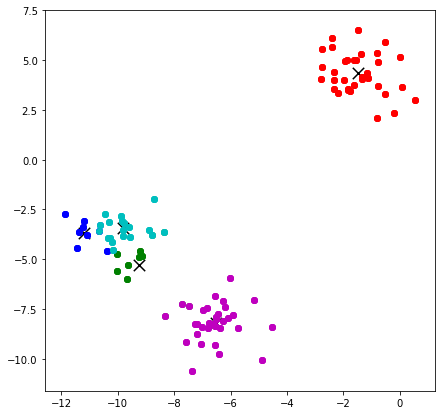

In [14]:
# определим максимальное количество итераций
max_iterations = 3

# и минимальное расстояние между центроидами до пересчета и после него, при котором нужно остановить алгоритм
min_distance = 1e-4

# сразу определим известное нам количество кластеров
k = 5

centroids, clusters = kmeans(X, k, max_iterations, min_distance)

visualize(centroids, clusters)

In [0]:
# Реализуем функцию вычисления среднего квадратичного внутриклассового расстояния
def calc_inner_distance(centroids, clusters):
  distances = np.zeros(len(centroids))
  result = 0

  for i, centroid in enumerate(centroids):
    for x in clusters[i]:
      distances[i] += e_metrics(x, centroid)**2
    result += distances[i] / len(clusters[i])
  return result

In [0]:
# Построим несколько моделей с разным количество кластеров
clusters_count_list = list(range(1,11))
cls = [kmeans(X, k, max_iterations, min_distance) for k in clusters_count_list]
inner_distances = [calc_inner_distance(centroids, clusters) for centroids, clusters in cls]

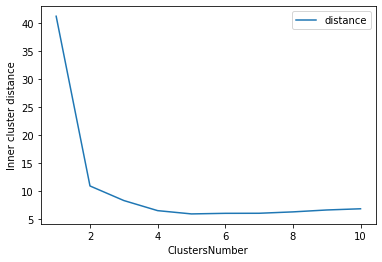

In [17]:
# Построим на графике зависимость среднеквадратичного внутрикластерного рассотояния от количества кластеров
plt.xlabel('ClustersNumber')
plt.ylabel('Inner cluster distance')
plt.plot(clusters_count_list, inner_distances, label='distance')
plt.legend(loc='upper right')
plt.show()